# Importing Core Libraries & Initializing the Modeling Ecosystem

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings("ignore")

Label mapping (original -> encoded):

np.float64(1.0): np.int64(0), : Normal

 np.float64(2.0): np.int64(1),: Benign
 
 np.float64(3.0): np.int64(2),: Malignant

# Data Ingestion & Target Engineering

In [5]:
df = pd.read_csv(
    r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\data\Ultrasound Fetus Dataset\FetusDataset.csv"
)

target_col = 'fetal_health'
X = df.drop(columns=[target_col])
y_raw = df[target_col]

le = LabelEncoder()
y = le.fit_transform(y_raw)

# Data Imputation & Feature Normalization

In [6]:
X = X.fillna(X.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train–Test Split for Robust Evaluation

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Model Initialization & Optimization-Ready Configuration

In [8]:
models = {}

try:
    from xgboost import XGBClassifier
    models['XGBoost'] = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42,
        n_estimators=100,
        n_jobs=1
    )
except Exception:
    models['XGBoost (sklearn fallback)'] = GradientBoostingClassifier(
        random_state=42,
        n_estimators=100
    )

models['RandomForest'] = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)
models['DecisionTree'] = DecisionTreeClassifier(random_state=42)
models['LogisticRegression'] = LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42)
models['SVM'] = SVC(probability=True, random_state=42)
models['KNN'] = KNeighborsClassifier(n_neighbors=5)
models['NaiveBayes'] = GaussianNB()


# Comparative Model Evaluation via Cross-Validation

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro'
}

results_cv = {}

for name, model in models.items():
    scores = cross_validate(
        model, X_scaled, y, cv=cv, scoring=scoring, 
        return_train_score=False, n_jobs=1
    )
    results_cv[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}


# Final Test Set Evaluation

In [10]:
test_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        try:
            auc = roc_auc_score(pd.get_dummies(y_test), y_proba, average='macro')
        except:
            auc = None
    else:
        auc = None

    test_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'auc_macro_ovr': auc,
        'classification_report': classification_report(
            y_test, y_pred, digits=4, target_names=[str(c) for c in le.classes_]
        )
    }


# Comprehensive Model Evaluation Summary

In [11]:
import pprint

print("Label mapping (original -> encoded):")
pprint.pprint(dict(zip(le.classes_, le.transform(le.classes_))))

print("\nCross-validation (5-fold Stratified) mean scores:")
pprint.pprint(results_cv)

print("\nTest set results:")
for name, res in test_results.items():
    print(f"\n=== {name} ===")
    print("Accuracy:", res['accuracy'])
    print("Precision (macro):", res['precision'])
    print("Recall (macro):", res['recall'])
    print("F1 (macro):", res['f1'])
    print("AUC (macro, OVR):", res['auc_macro_ovr'])
    print("Classification report:\n", res['classification_report'])


Label mapping (original -> encoded):
{np.float64(1.0): np.int64(0),
 np.float64(2.0): np.int64(1),
 np.float64(3.0): np.int64(2)}

Cross-validation (5-fold Stratified) mean scores:
{'DecisionTree': {'accuracy': np.float64(0.9125103562551781),
                  'f1': np.float64(0.8562849143349739),
                  'precision': np.float64(0.8545382963210016),
                  'recall': np.float64(0.8602845476581971)},
 'KNN': {'accuracy': np.float64(0.9063949185307927),
         'f1': np.float64(0.8221192706587723),
         'precision': np.float64(0.8684573230531875),
         'recall': np.float64(0.7891401743872429)},
 'LogisticRegression': {'accuracy': np.float64(0.896051919359293),
                        'f1': np.float64(0.796746043915319),
                        'precision': np.float64(0.8213490649355437),
                        'recall': np.float64(0.7792916706967605)},
 'NaiveBayes': {'accuracy': np.float64(0.7431980115990058),
                'f1': np.float64(0.666050321129

# Confusion Matrix Visualization for All Models

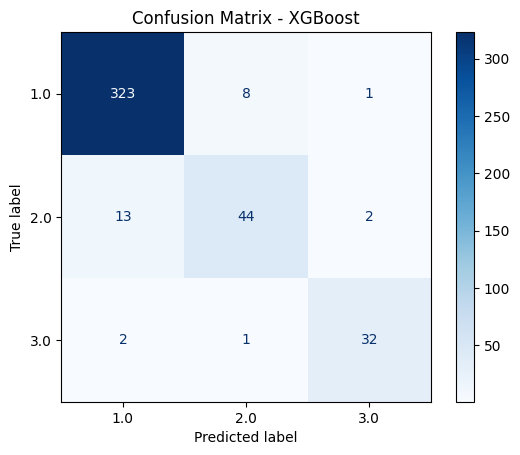

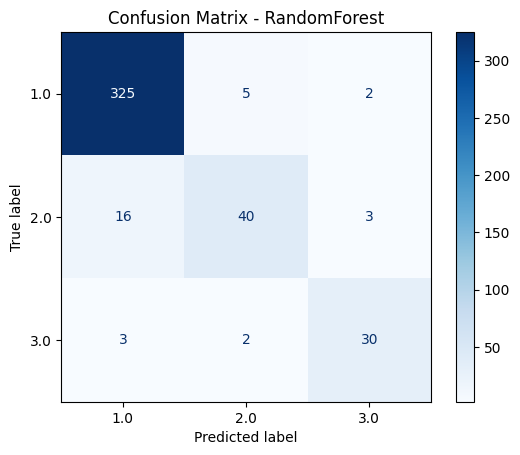

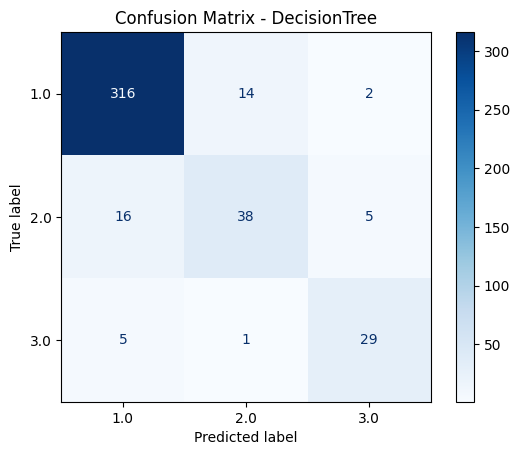

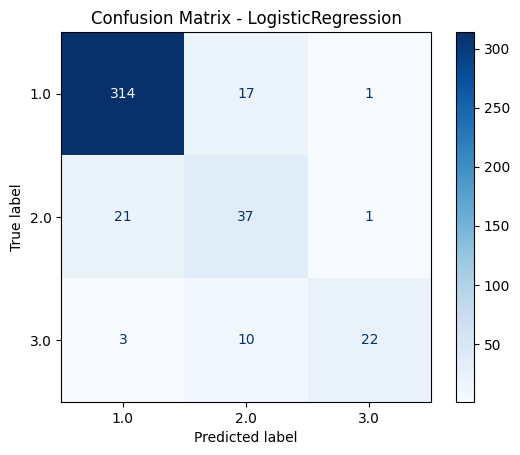

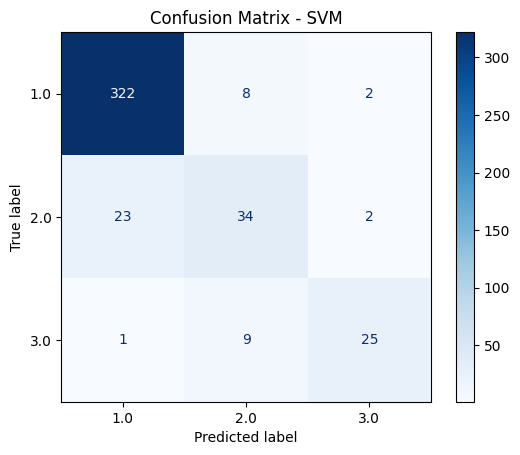

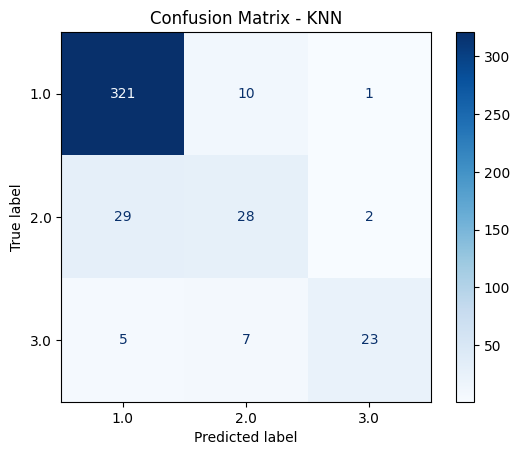

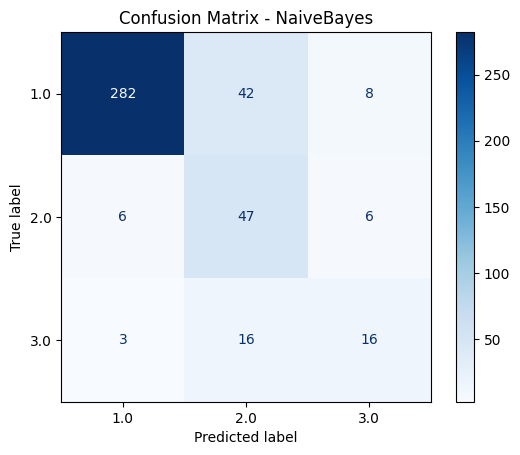

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in models.items():
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# Model Registry Verification

In [13]:
print(models.keys())

dict_keys(['XGBoost', 'RandomForest', 'DecisionTree', 'LogisticRegression', 'SVM', 'KNN', 'NaiveBayes'])


# Model Initialization with XGBoost Fallback Logic

In [14]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Flag to track if real XGB is used
use_real_xgb = True

try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = GradientBoostingClassifier
    use_real_xgb = False

# Initialize models
models = {
    "RF": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "XGB": XGBClassifier()
}

# Optional transparency log
if not use_real_xgb:
    print("⚠ XGBoost not found. Using GradientBoostingClassifier as fallback.")


# Cross-Validation Accuracy Comparison (Bar Chart Visualization)

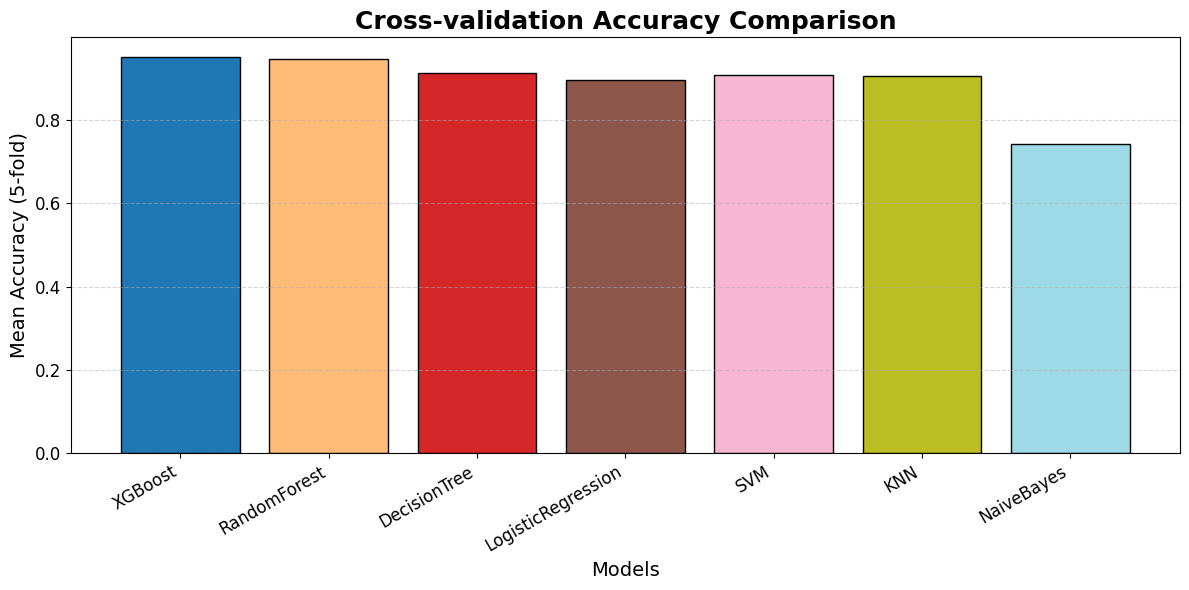

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Extract model names and mean accuracy scores from results_cv
models_names = list(results_cv.keys())
mean_scores = [float(results_cv[name]['accuracy']) for name in models_names]

plt.figure(figsize=(12, 6))

# Use a dynamic color map for diversity
colors = plt.cm.tab20(np.linspace(0, 1, len(mean_scores)))

plt.bar(models_names, mean_scores, color=colors, edgecolor='black')

plt.title('Cross-validation Accuracy Comparison', fontsize=18, weight='bold')
plt.ylabel('Mean Accuracy (5-fold)', fontsize=14)
plt.xlabel('Models', fontsize=14)

# Improve tick readability
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add grid for visual guidance
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# Feature Importance Ranking from Tree-Based Model

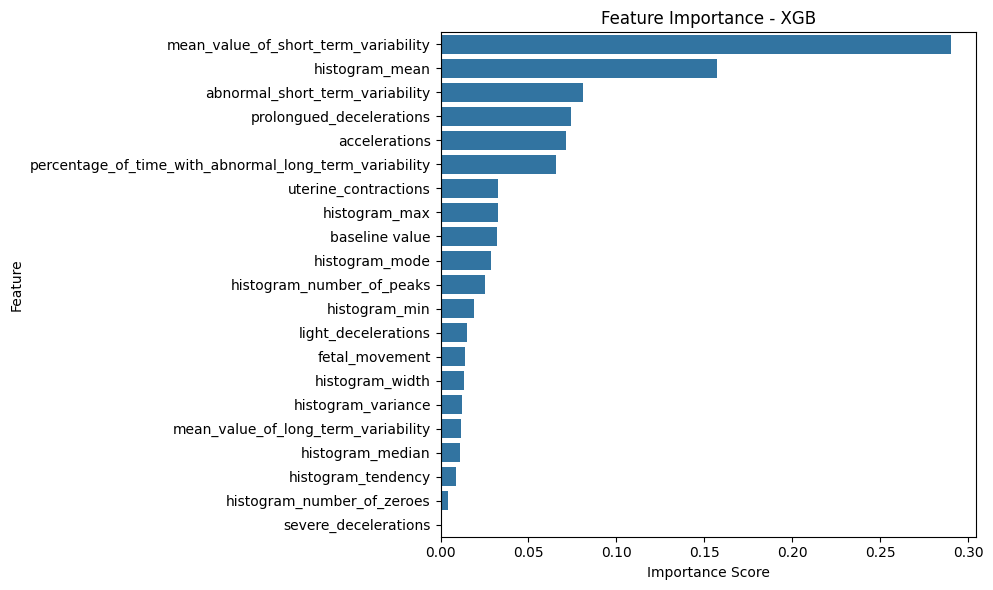

In [16]:
import seaborn as sns

# try common keys for the XGBoost model and fallbacks
xgb_keys = ['XGBoost', 'XGB', 'XGBoost (sklearn fallback)']
model = None
selected_key = None

for k in xgb_keys:
	if k in models:
		model = models[k]
		selected_key = k
		break

# if not found, pick any model that exposes feature_importances_
if model is None:
	for k, m in models.items():
		if hasattr(m, "feature_importances_"):
			model = m
			selected_key = k
			break

if model is None:
	raise KeyError("No model with feature_importances_ found. Available models: " + ", ".join(models.keys()))

# ensure the model is fitted (most models were trained earlier)
if not hasattr(model, "feature_importances_"):
	try:
		model.fit(X_train, y_train)
	except Exception as e:
		raise RuntimeError(f"Model '{selected_key}' has no feature_importances_ and couldn't be fitted: {e}")

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=np.array(X.columns)[indices])
plt.title(f"Feature Importance - {selected_key}")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Model Explainability Using SHAP (TreeExplainer)

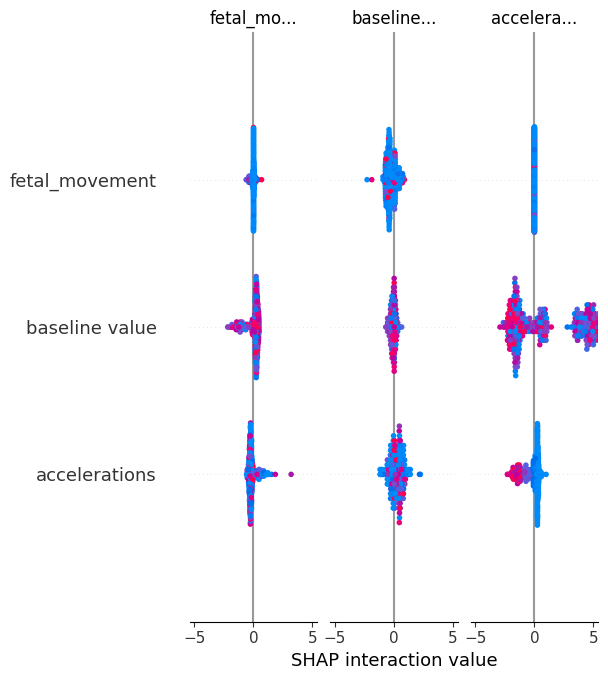

In [17]:
import shap

explainer = shap.TreeExplainer(models['XGB'])  # Use correct model key
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)


# Fetal Health Class Distribution Visualization

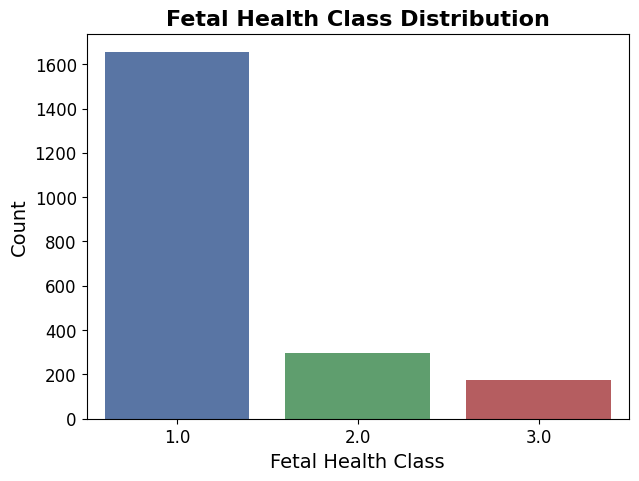

In [18]:
plt.figure(figsize=(7,5))

sns.countplot(
    x='fetal_health',
    data=df,
    palette=['#4C72B0', '#55A868', '#C44E52']   # blue, green, red
)

plt.title('Fetal Health Class Distribution', fontsize=16, weight='bold')
plt.xlabel('Fetal Health Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


# Feature Correlation Matrix for Ultrasound Dataset

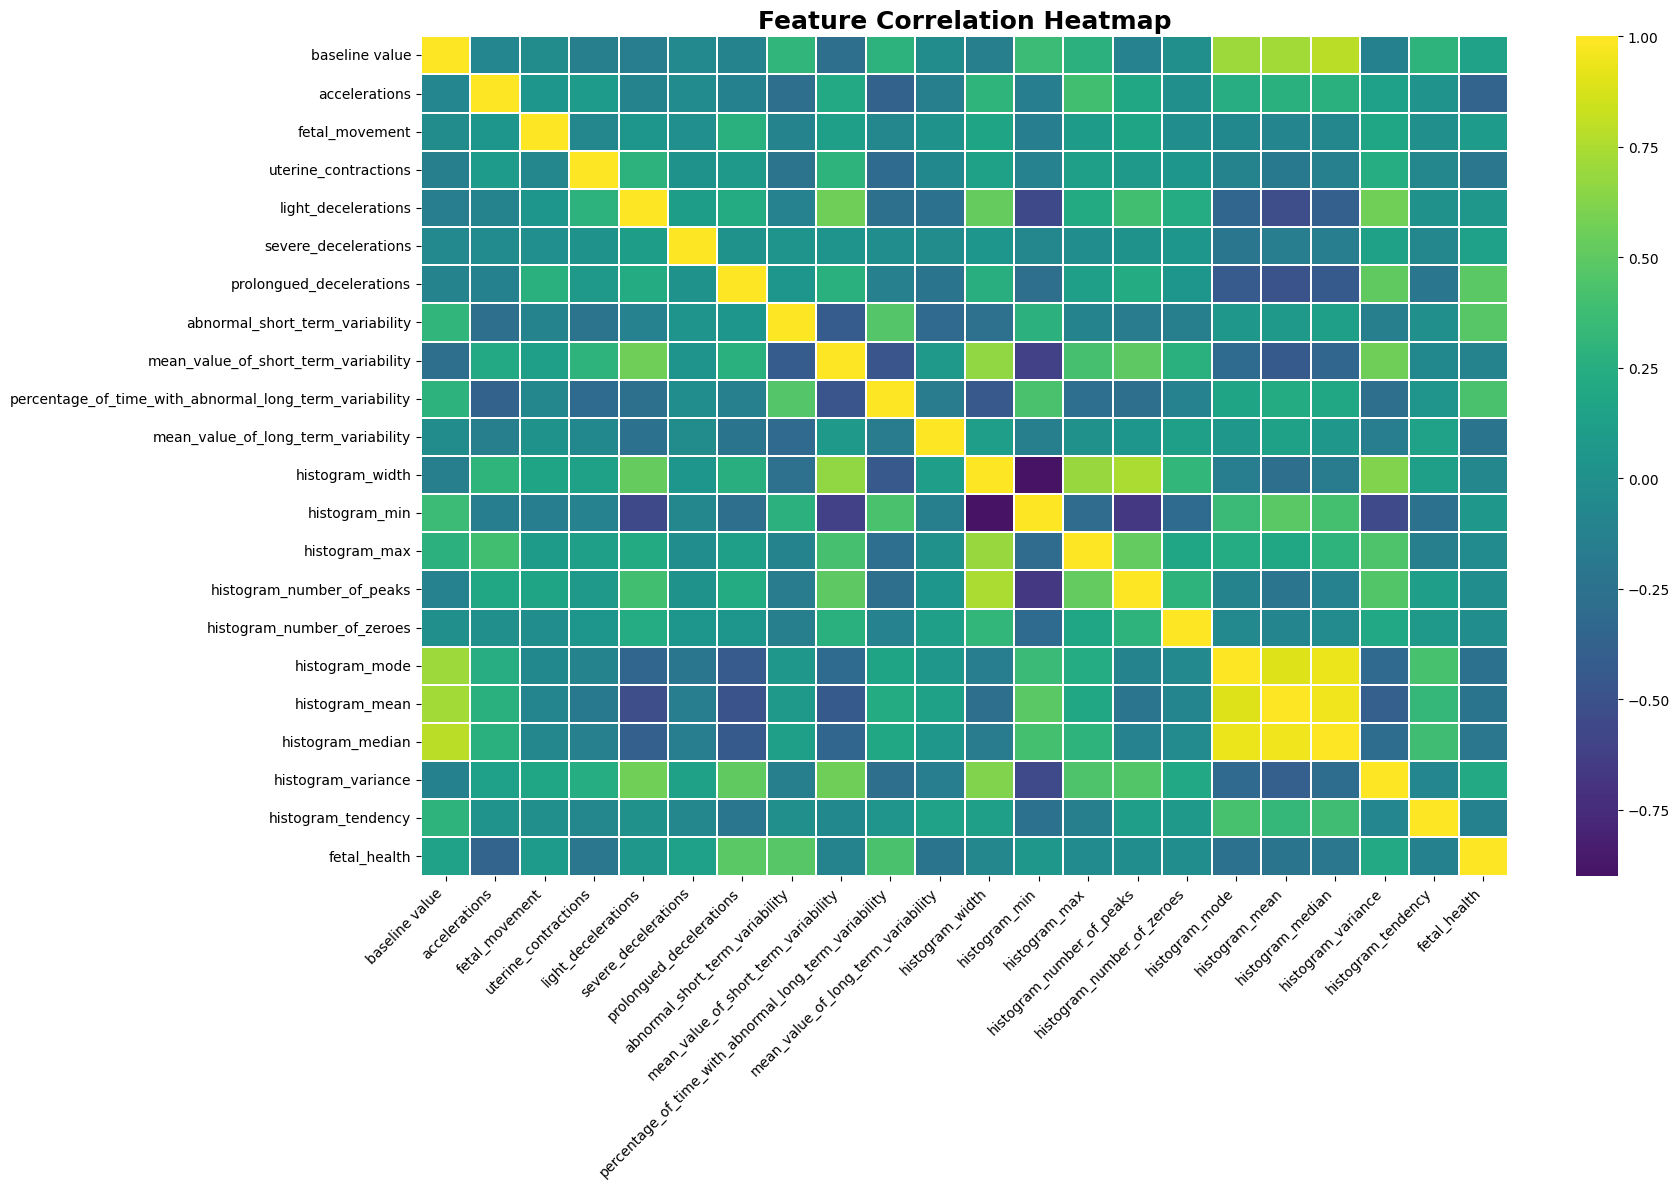

In [19]:
plt.figure(figsize=(18,12))

sns.heatmap(
    df.corr(),
    cmap='viridis',
    center=0,
    linewidths=0.3,
    linecolor='white'
)

plt.title("Feature Correlation Heatmap", fontsize=18, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


# 2D PCA Projection for Visualizing Class Separability

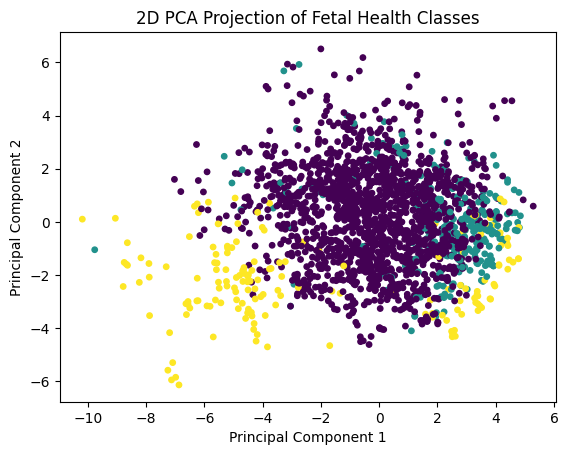

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', s=15)
plt.title("2D PCA Projection of Fetal Health Classes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


# Model Performance Benchmark: Cross-Validation vs Test Accuracy

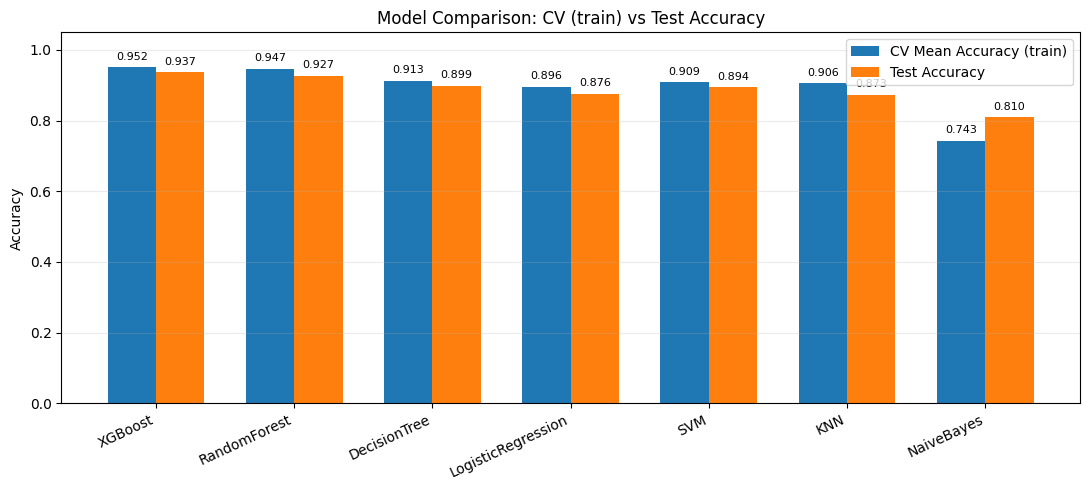

In [21]:
model_names = list(results_cv.keys())
train_acc = [results_cv[m]['accuracy'] for m in model_names]
test_acc = [test_results[m]['accuracy'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(11,5))
bars1 = plt.bar(x - width/2, train_acc, width, label='CV Mean Accuracy (train)')
bars2 = plt.bar(x + width/2, test_acc,  width, label='Test Accuracy')

plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.title('Model Comparison: CV (train) vs Test Accuracy')
plt.xticks(x, model_names, rotation=25, ha='right')
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.25)

for b in bars1 + bars2:
    h = b.get_height()
    plt.annotate(f'{h:.3f}', xy=(b.get_x() + b.get_width() / 2, h),
                 xytext=(0, 4), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
